## Load libraries and data

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV,  StratifiedKFold
from sklearn.linear_model import Lasso

import warnings 
warnings.filterwarnings('ignore')

In [65]:
# Load train and test data
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")

In [66]:
# Assign `is_fraud` column as y
X_train = train_df.loc[:, train_df.columns != 'is_fraud']
y_train = train_df['is_fraud']

X_test = test_df.loc[:, test_df.columns != 'is_fraud']
y_test = test_df['is_fraud']

# Standardize numerical columns
scaler_train = StandardScaler()
numeric_cols_train = X_train.select_dtypes(include=['number'])
X_train[numeric_cols_train.columns] = scaler_train.fit_transform(numeric_cols_train)

scaler_test = StandardScaler()
numeric_cols_test = X_test.select_dtypes(include=['number'])
X_test[numeric_cols_test.columns] = scaler_test.fit_transform(numeric_cols_test)

### Undersampling majority class: Random Undersampling

In [67]:
# Apply random undersampling to train dataset
rus = RandomUnderSampler(sampling_strategy=0.1, random_state=123)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print(f'Size of X_train after random undersampling: {len(X_train_rus)}')

Size of X_train after random undersampling: 80256


### Oversampling minority class: SMOTE-NC

In [68]:
# Obtain indices for categorical variables
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]

# Apply SMOTE-NC on training data
sm = SMOTENC(categorical_features=categorical_columns_idx, random_state=123, sampling_strategy=0.5)
X_train_smote, y_train_smote = sm.fit_resample(X_train_rus, y_train_rus)

print(f'Train data size:{len(X_train_smote)}')
print(f'Fraud proportion in train data: {round(y_train_smote.mean(), 2)}')

Train data size:109440
Fraud proportion in train data: 0.33


### One-hot encoding (for random forest)

In [69]:
# Apply one-hot encoding on train and test data
X_train_ohe = pd.get_dummies(X_train_smote, drop_first = True)
X_test_ohe = pd.get_dummies(X_test, drop_first = True)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns, fill_value=0)

print(f'Number of columns after one-hot encoding: {len(X_train_ohe.columns)}')

Number of columns after one-hot encoding: 1183


### Feature selection

##### SelectKBest

In [70]:
selector = SelectKBest(score_func=f_classif, k=30)
X_train_kbest = selector.fit_transform(X_train_ohe,y_train_smote)
X_test_kbest = selector.transform(X_test_ohe)

##### Lasso

In [24]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train_ohe, y_train_smote)
feature_importance = pd.Series(lasso.coef_, index=X_train_ohe.columns)
selected_features = feature_importance[feature_importance != 0].index.tolist()
X_train_lasso = X_train_ohe.loc[:, selected_features]
X_test_lasso = X_test_ohe.loc[:, selected_features]

##### RFECV

In [24]:
# Run RFECV with step = 0.1 first to narrow down to a rough figure
cv_split = StratifiedKFold(5, shuffle=True, random_state=123)
model = RandomForestClassifier(random_state=123)

rfecv_estimate = RFECV(
    estimator=model,
    step=0.1,
    min_features_to_select=5,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose = 1
)

rfecv_estimate.fit(X_train_ohe, y_train_smote)

print(f"Optimal number of features: {rfecv_estimate.n_features_}")

Fitting estimator with 1183 features.
Fitting estimator with 1183 features.
Fitting estimator with 1183 features.
Fitting estimator with 1183 features.
Fitting estimator with 1183 features.
Fitting estimator with 1065 features.
Fitting estimator with 1065 features.
Fitting estimator with 1065 features.
Fitting estimator with 1065 features.
Fitting estimator with 1065 features.
Fitting estimator with 947 features.
Fitting estimator with 947 features.
Fitting estimator with 947 features.
Fitting estimator with 947 features.
Fitting estimator with 947 features.
Fitting estimator with 829 features.
Fitting estimator with 829 features.
Fitting estimator with 829 features.
Fitting estimator with 829 features.
Fitting estimator with 829 features.
Fitting estimator with 711 features.
Fitting estimator with 711 features.
Fitting estimator with 711 features.
Fitting estimator with 711 features.
Fitting estimator with 711 features.
Fitting estimator with 593 features.
Fitting estimator with 593 f

In [25]:
# Run RFECV again on selected features to further narrow down to more precise number of features

top_features = np.where(rfecv_estimate.support_)[0]
X_rfecv_estimate = X_train_ohe.iloc[:, top_features]

rfecv_fine = RFECV(estimator=model,
    step=5,
    min_features_to_select=5,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose = 2)
rfecv_fine.fit(X_rfecv_estimate, y_train_smote)

print(f"Optimal number of features: {rfecv_fine.n_features_}")

selected_columns = rfecv_fine.get_feature_names_out()
X_train_rfecv = X_train_ohe[selected_columns]
X_test_rfecv = X_test_ohe[selected_columns]

Fitting estimator with 121 features.
Fitting estimator with 121 features.
Fitting estimator with 121 features.
Fitting estimator with 121 features.
Fitting estimator with 121 features.
Fitting estimator with 116 features.
Fitting estimator with 116 features.
Fitting estimator with 116 features.
Fitting estimator with 116 features.
Fitting estimator with 116 features.
Fitting estimator with 111 features.
Fitting estimator with 111 features.
Fitting estimator with 111 features.
Fitting estimator with 111 features.
Fitting estimator with 111 features.
Fitting estimator with 106 features.
Fitting estimator with 106 features.
Fitting estimator with 106 features.
Fitting estimator with 106 features.
Fitting estimator with 106 features.
Fitting estimator with 101 features.
Fitting estimator with 101 features.
Fitting estimator with 101 features.
Fitting estimator with 101 features.
Fitting estimator with 101 features.
Fitting estimator with 96 features.
Fitting estimator with 96 features.
Fit

In [25]:
# # Run this cell to skip waiting for RFECV

# selected_columns = ['zip', 'city_pop', 'amt', 'hour', 'year', 'age', 'prev_trans_fraud', 'count_fraud_prev10', 'acc_fraud_count', 'merchant_prev_trans_fraud', 
#                     'merchant_count_fraud_prev10', 'merchant_acc_fraud_count', 'transaction_risk_score', 'hourly_risk_score', 'interval', 'first_second_purchase',
#                     'interval_deviation', 'visited_cat', 'category_first_purchase', 'amt_deviation', 'city_population_class', 'gender_M', 'category_food_dining',
#                     'category_gas_transport', 'category_grocery_net', 'category_grocery_pos', 'category_health_fitness', 'category_kids_pets', 'category_shopping_net', 
#                     'month_2021-02-01', 'month_2021-08-01', 'trans_quarter_2021Q2', 'trans_quarter_2021Q3', 'trans_quarter_2021Q4', 'trans_quarter_2022Q1', 'trans_quarter_2022Q4']
# X_train_rfecv = X_train_ohe[selected_columns]
# X_test_rfecv = X_test_ohe[selected_columns]

## Base model

accuracy: 0.9993665158371041, precision: 0.9419415460380987, recall: 0.9947045454545455, f1: 0.9668219977661145


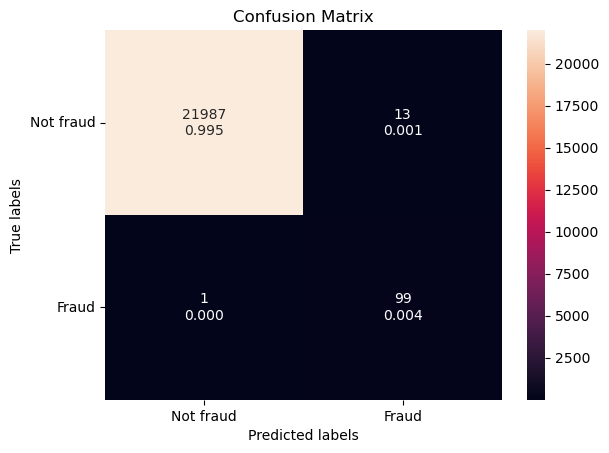

In [38]:
# Run basic random forest model using SelectKBest dataset

clf = RandomForestClassifier(max_depth=6, random_state=123)
clf.fit(X_train_kbest, y_train_smote)

# Use trained model to make predictions on test data
y_pred = clf.predict(X_test_kbest)
# Evaluate performance
print(f"accuracy: {accuracy_score(y_test, y_pred)}, precision: {precision_score(y_test, y_pred, average='macro', zero_division = 0.0)}, recall: {recall_score(y_test, y_pred, average='macro')}, f1: {f1_score(y_test, y_pred, average='macro', zero_division = 0.0)}")


ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Plot confusion matrix
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

accuracy: 0.9980542986425339, precision: 0.8496503496503496, recall: 0.9990227272727272, f1: 0.9110335193830934


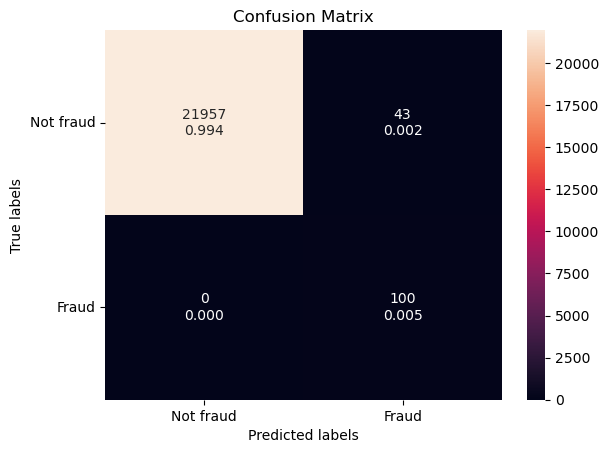

In [35]:
# Running with Lasso instead

clf = RandomForestClassifier(max_depth=6, random_state=123)
clf.fit(X_train_lasso, y_train_smote)

# Use trained model to make predictions on test data
y_pred = clf.predict(X_test_lasso)
# Evaluate performance
print(f"accuracy: {accuracy_score(y_test, y_pred)}, precision: {precision_score(y_test, y_pred, average='macro', zero_division = 0.0)}, recall: {recall_score(y_test, y_pred, average='macro')}, f1: {f1_score(y_test, y_pred, average='macro', zero_division = 0.0)}")


ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Plot confusion matrix
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

accuracy: 0.9987782805429865, precision: 0.8937007874015748, recall: 0.9993863636363636, f1: 0.9402216277890187


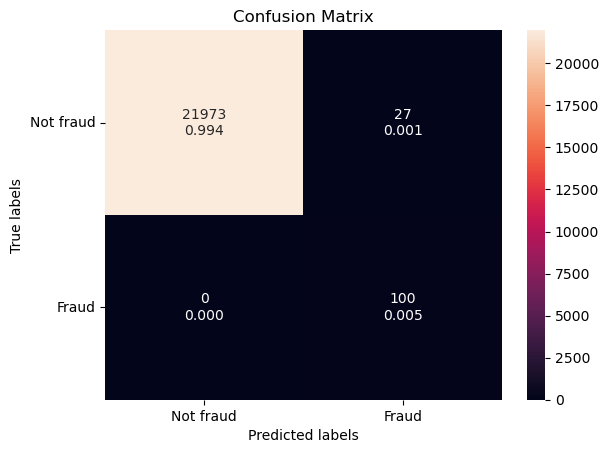

In [36]:
# Running with RFECV instead

clf = RandomForestClassifier(max_depth=6, random_state=123)
clf.fit(X_train_rfecv, y_train_smote)

# Use trained model to make predictions on test data
y_pred = clf.predict(X_test_rfecv)
# Evaluate performance
print(f"accuracy: {accuracy_score(y_test, y_pred)}, precision: {precision_score(y_test, y_pred, average='macro', zero_division = 0.0)}, recall: {recall_score(y_test, y_pred, average='macro')}, f1: {f1_score(y_test, y_pred, average='macro', zero_division = 0.0)}")


ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Plot confusion matrix
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

## With GridSearchCV

In [28]:
# Apply GridSearchCV to tune hyperparameters
clf2 = RandomForestClassifier(random_state=123)

params = {'n_estimators': [150, 200, 250], 
         'max_features': ['sqrt', 'log2', 20],
         'max_depth': [10, 15, 20],
         'criterion': ['gini', 'entropy']}
cv = GridSearchCV(estimator = clf2, param_grid = params, cv = 5, n_jobs = -1, verbose = 2, scoring = 'f1')

cv.fit(X_train_kbest, y_train_smote)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=150; total time=  23.6s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=150; total time=  23.9s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=150; total time=  24.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=150; total time=  24.2s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=150; total time=  24.3s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200; total time=  31.5s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200; total time=  32.1s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200; total time=  32.2s
[CV] END criterion=gini, max_depth=10, max_features=log2, n_estimators=150; total time=  21.8s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200; total t

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20],
                         'max_features': ['sqrt', 'log2', 20],
                         'n_estimators': [150, 200, 250]},
             scoring='f1', verbose=2)

In [72]:
# Report model performance
print(f'Chosen hyperparameters: {cv.best_params_}')
cv_best_model = cv.best_estimator_
print(f'CV F1: {round(cv.best_score_, 2)}')

# Run model on test data
y_pred_cv = cv_best_model.predict(X_test_kbest)
# Evaluate model
print(f'Test accuracy: {accuracy_score(y_test, y_pred_cv)}, precision: {precision_score(y_test, y_pred_cv, average='macro', zero_division = 0.0)}, recall: {recall_score(y_test, y_pred_cv, average='macro')}, f1: {f1_score(y_test, y_pred_cv, average='macro', zero_division = 0.0)}')

# Print top 10 most important features
importance= pd.DataFrame({
    'Feature': selector.get_feature_names_out(),
    'Importance': cv_best_model.feature_importances_
})

print('\nTop 10 most important features:')
importance.sort_values(by='Importance', ascending=False)[:10]

Chosen hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 250}
Test accuracy: 0.9993510183375406, precision: 0.9182402573859311, recall: 0.996627004506371, f1: 0.9540504192396693

Top 10 most important features:


,Feature,Importance
3,prev_trans_fraud,0.253232
4,count_fraud_prev10,0.224867
0,amt,0.116212
6,merchant_prev_trans_fraud,0.095709
7,merchant_count_fraud_prev10,0.077946
14,visited_cat,0.069145
10,hourly_risk_score,0.034531
1,hour,0.028499
5,acc_fraud_count,0.023204
16,amt_deviation,0.022652


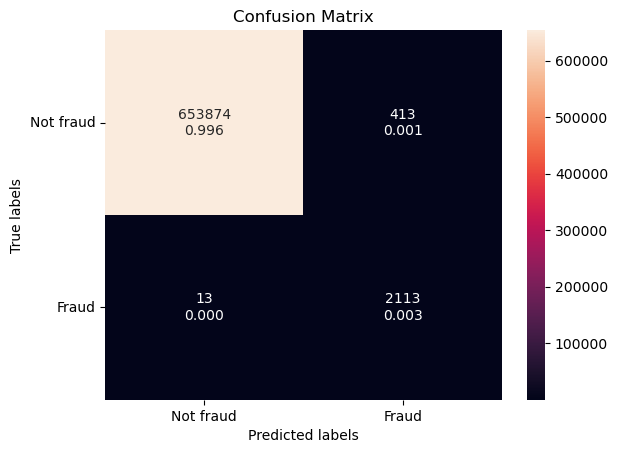

AUC: 1.00


In [75]:
ax= plt.subplot()
cm = confusion_matrix(y_test, y_pred_cv)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
values = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Plot confusion matrix
sns.heatmap(cm, annot=values, fmt='')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud']); 
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation = 0)
plt.show()

auc = roc_auc_score(y_test, y_pred_cv)
print(f'AUC: {auc:.2f}')